# Using Principal Component Analysis (PCA) to reduce the dimensionality of the TCGA gene expression data


What does the gene expression data _look_ like when its dimensionality is reduced by PCA? Considering that disease alone appears to be on par with the expression data at predicting some mutations... how much of the reduced (via PCA) gene expression data is just capturing disease information?

Most of this is probably already self-evident to someone with some biology experience but as a layman I found it helpful to see some of these graphs.

## Outline:
1. Imports, constants and load the data
2. Run PCA
3. Evaluate how much variance is explained by the PCA components
4. Visualize the components relative to two covariates:
    * Disease (which I think is also a good proxy for organ... I include a plot relative to organ)
    * Gender
5. Visualize the effect of gender on expression data apart from disease

### 1. Imports, constants and load the data

In [1]:
# Imports
import os
import operator

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
# Constants. The random seed to use throughout and the number of components to be returned by PCA (7,306 being the full set)
RandomSeed = 0
TotalComponents = 7306

In [3]:
# Load the data (I'm using the pickled versions because they are significantly faster to load... ~20 sec as opposed to 7 minutes)
try: 
    path = os.path.join('..', '..', 'download', 'expression-matrix.pkl')
    X = pd.read_pickle(path)
except:
    path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
    X = pd.read_table(path, index_col=0)

try:
    path = os.path.join('..', '..', 'download', 'mutation-matrix.pkl')
    Y = pd.read_pickle(path)
except:
    path = os.path.join('..', '..', 'download', 'mutation-matrix.tsv.bz2')
    Y = pd.read_table(path, index_col=0)
    
path = os.path.join('..', '..', 'download', 'samples.tsv')
samples = pd.read_table(path, index_col=0)

# Replace missing gender info with 'unknown'
samples.fillna('unknown', inplace=True)

### 2. Run PCA

In [4]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components = TotalComponents, random_state = RandomSeed)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

### 3. Evaluate how much variance is explained by the components

In [5]:
def PlotExplainedVariance(pcaInput, views):
    """ 
    Plot the relationship between the number of 
    components and the percent of variance explained
    """
    # Plot the explained variance for each view
    for view in views:
        # Create the list to use as the X values
        n_component_list = []
        for value in range(views[view][0]+1,views[view][1]+1):
            n_component_list.append(value)
        # Create the plot
        plt.figure(figsize=(5, 5))
        plt.axes([.2, .2, .7, .7])
        plt.plot(n_component_list, pcaInput.explained_variance_ratio_.cumsum()[views[view][0]:views[view][1]]*100, linewidth=2)
        plt.axis('tight')
        plt.xlabel('Number of Components')
        plt.ylabel('Percent of Variance Explained')
        plt.title(view)
        plt.show()

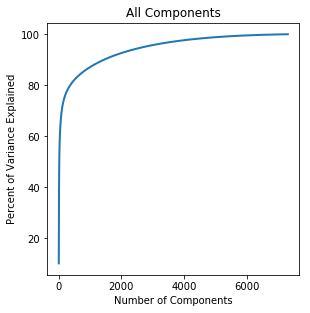

In [6]:
PlotExplainedVariance(pca, {'All Components':[0,TotalComponents]})

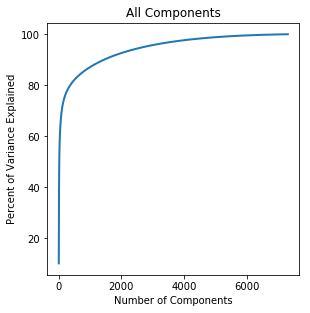

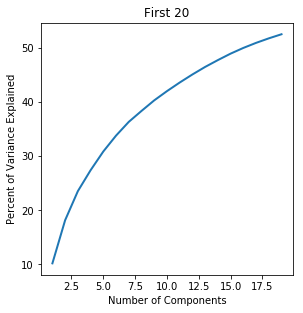

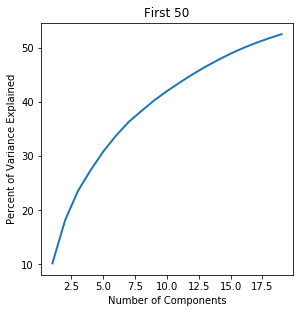

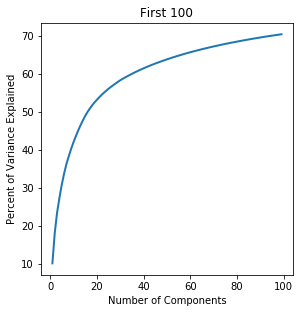

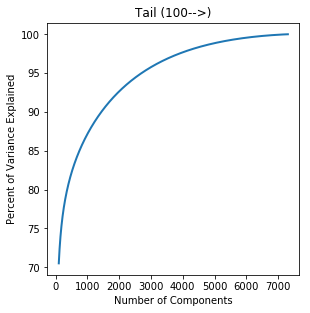

In [7]:
# Set differnt views to plot (n_components)
views = {
        'All Components': [0,TotalComponents], 
        'First 20': [0,19],
        'First 50': [0,19],
        'First 100': [0,99],
        'Tail (100-->)': [99,TotalComponents]
            }
PlotExplainedVariance(pca, views)

In [8]:
def ComponentsToExplainVariance():
    """
    Create a dictionary of (threshold: number of components) for some points of reference
    """
    varianceLimits = [0.25,0.4, 0.5, 0.6,0.7, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 1]
    varianceLimitsDict = dict.fromkeys(varianceLimits)
    for i in range(TotalComponents):
        if pca.explained_variance_ratio_.cumsum()[i] > varianceLimits[0]:
            varianceLimitsDict[varianceLimits[0]] = i
            varianceLimits.pop(0)
    return varianceLimitsDict
compDict = ComponentsToExplainVariance()


In [9]:
for i in compDict:
    print(str(int(i*100)),"% of variance is explained by ", str(compDict[i]), " components.")

25 % of variance is explained by  3  components.
40 % of variance is explained by  8  components.
50 % of variance is explained by  16  components.
60 % of variance is explained by  35  components.
70 % of variance is explained by  94  components.
75 % of variance is explained by  176  components.
80 % of variance is explained by  363  components.
90 % of variance is explained by  1439  components.
95 % of variance is explained by  2704  components.
98 % of variance is explained by  4229  components.
99 % of variance is explained by  5166  components.
100 % of variance is explained by  None  components.


### 4. Visualize the components relative to disease and gender

In [10]:
def PlotAttributes(component1,component2, attribute='acronym',proportionShown='All', pointSize=20, X=X_pca, samples=samples, colors=None):
    """ 
    Plot each sample as a point, colored by attribute, relative to two principal components (component1 and component2)
    """
    title = attribute
    # Get the attributes
    y = samples[attribute]
    # Optional: Subset the data to make it easier to see what's going on (7,000 is a bit 
    # too many points for this scatter plot)
    if proportionShown is not 'All':
        X_show, X_removed, y_show, y_removed = train_test_split(X, y, test_size=1-proportionShown, stratify=y, random_state=RandomSeed)
    else:
        X_show = X
        y_show = y
    # Get a list of the attributes
    attributes = np.unique(y_show)
    # Create the plot
    fig = plt.figure(figsize=(5, 5))
    labels = attributes
    if colors:
        colors=colors
    else:
        colors=iter(cm.nipy_spectral(np.linspace(0,1,len(attributes))))
    ax = fig.add_subplot(1, 1, 1)
    markers = ['o','s','D','>']
    for attribute, label, color in zip(attributes, labels, colors):
        ax.scatter(X_show[np.where(y_show == attribute), component1],
                   X_show[np.where(y_show == attribute), component2],
                   marker = markers[list(attributes).index(attribute)%len(markers)], label=attribute, color=color, linewidth='0.2', s=pointSize, alpha=0.9)
        ax.legend(loc='best')
    plt.xlabel("Principal Component %s " %str(component1+1))
    plt.ylabel("Principal Component %s " %str(component2+1))
    plt.title("{} (PC{} and PC{})".format(title,component1+1,component2+1))
    if len(attributes) > 12:
        numberColumns = 2
    else:
        numberColumns = 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=numberColumns, borderaxespad=0.)
    plt.show()
    
def PlotAttributesMultiPlots(LastComponent, attribute='acronym',proportionShown = 'All',pointSize=20, X=X_pca, samples=samples, colors=None):
    """ 
    Create multiple plots on two principal components.
    Takes a number (LastComponent) and plots each set of two components going
    up starting from 0,1 the 2,3... up until (LastComponent-2),(LastComponent-1)
    """
    OddList = [x for x in range(LastComponent) if x % 2 == 0]
    for i in OddList:
        PlotAttributes(i,i+1, attribute,proportionShown,pointSize, X=X_pca, samples=samples, colors=colors)

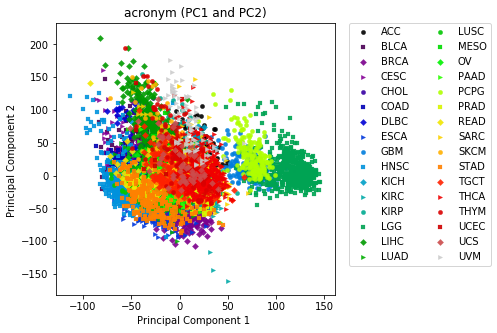

In [11]:
PlotAttributes(0,1,attribute='acronym')

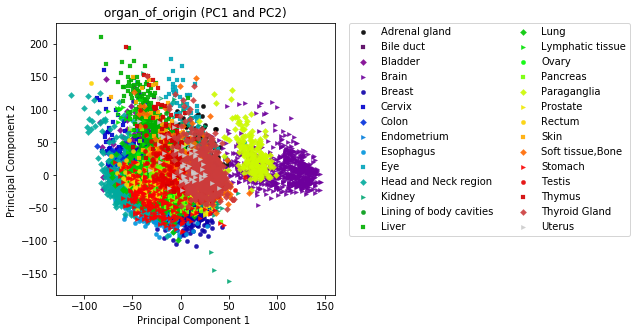

In [12]:
PlotAttributes(0,1,attribute='organ_of_origin')

### First ten principal components relative to disease
### (There looks to be a strong correlation)



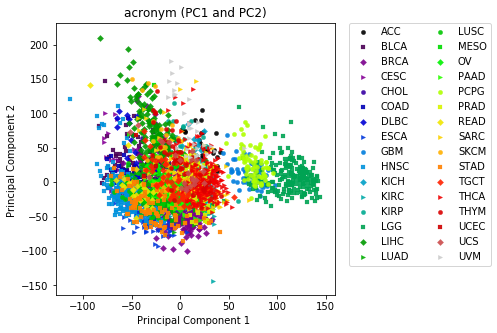

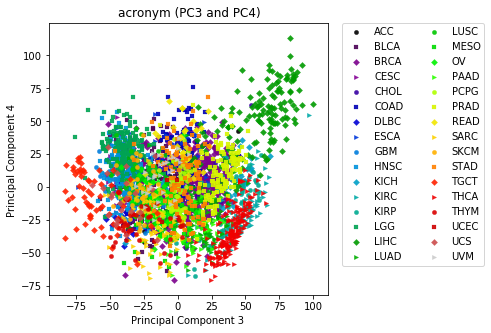

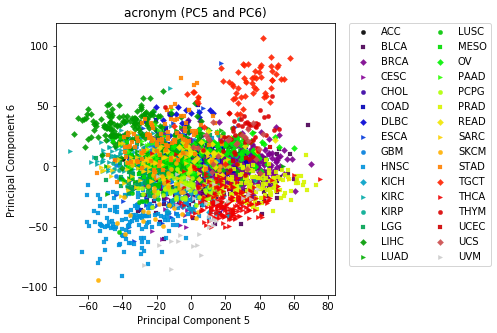

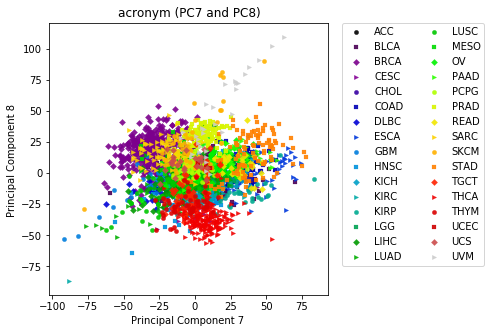

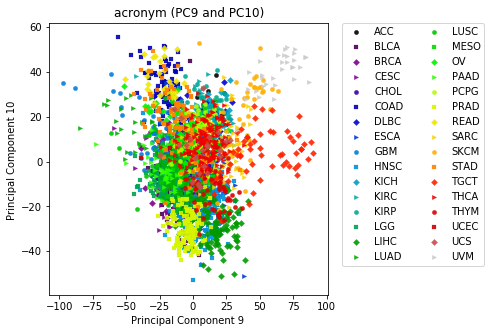

In [13]:
PlotAttributesMultiPlots(10,attribute='acronym',proportionShown=0.4)

### First 10 components relative to gender

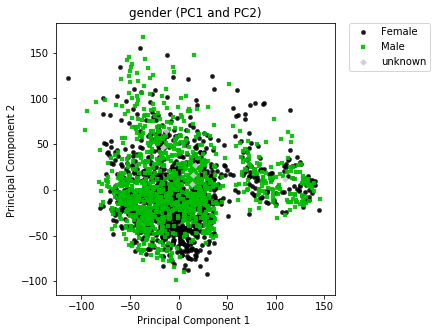

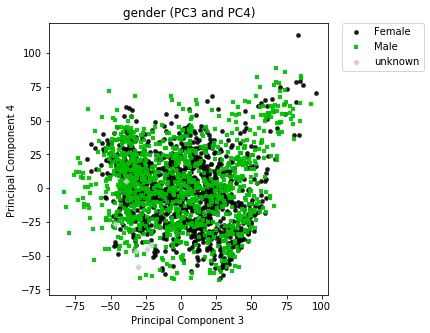

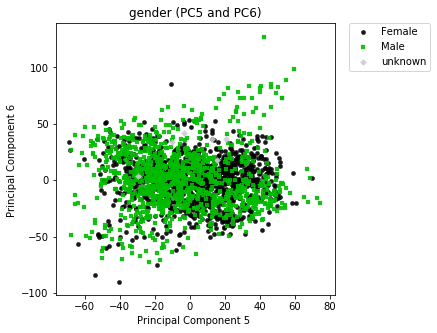

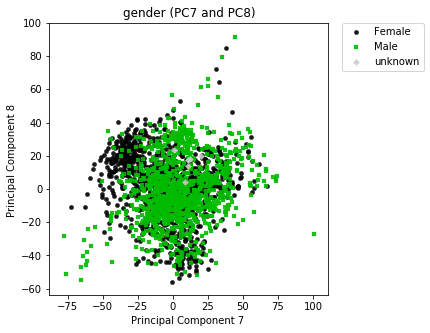

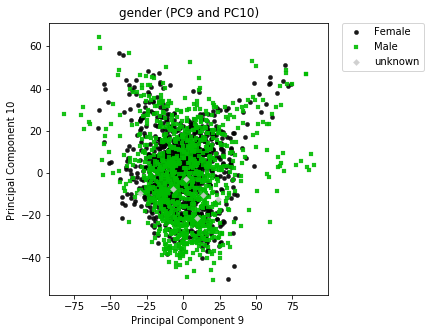

In [14]:
PlotAttributesMultiPlots(10,attribute='gender',proportionShown=0.3)

## 5. Visualize the relationship between gender and expression apart from disease

Select a few diseases that are fairly gender neutral run pca on only samples in those diseases and plot gender against a few Principal Components for each

(As shown by the plots below, there's still no easy to see correlation between expression principal components and gender even when disease is removed from the mix. I'm suprised that each disease seems to have a similar two clusters when the first two principal components are plotted)

In [15]:
# Get a list of the gender neutral diseases (no more than 70% a particular gender)
diseaseDict = dict.fromkeys(np.unique(samples['acronym']))
# Create a dictionary with disease: [ration male, number of samples]
for disease in diseaseDict:
    tempDF = samples.loc[samples['acronym'] == disease]
    males = tempDF['gender'].value_counts()[0]
    genderRatio = males / tempDF.shape[0]
    diseaseDict[disease] = [genderRatio, tempDF.shape[0]]
# Remove the non gender neutral diseases
neutralDiseaseDict = dict(diseaseDict)
for disease in diseaseDict:
    if 0.3 < diseaseDict[disease][0] < 0.7  :
        pass
    else:
        del neutralDiseaseDict[disease]
neutralDiseaseList = list(neutralDiseaseDict.keys())
# Print the list for reference
print(neutralDiseaseList)

['ACC', 'CHOL', 'COAD', 'DLBC', 'GBM', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'PAAD', 'PCPG', 'READ', 'SARC', 'SKCM', 'STAD', 'THYM', 'UVM']


@gwaygenomics recomended that breast cancer (BRCA) also be added to this list "BRCA is a good control as there are some male BRCA samples in the dataset. (although there are stronger signals in the data that should be explained by top PCs)." so BRCA is appended to the list below.

In [16]:
neutralDiseaseList.append('BRCA')
print(neutralDiseaseList)

['ACC', 'CHOL', 'COAD', 'DLBC', 'GBM', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'PAAD', 'PCPG', 'READ', 'SARC', 'SKCM', 'STAD', 'THYM', 'UVM', 'BRCA']


ACC


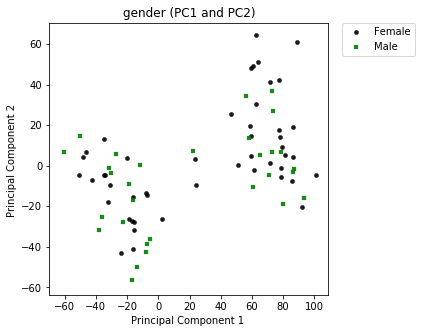

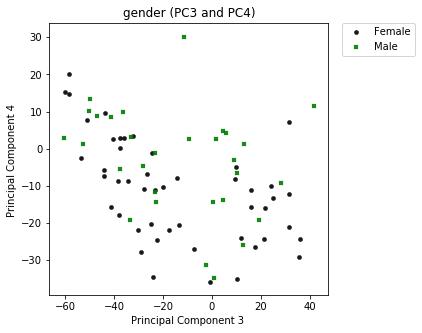

CHOL


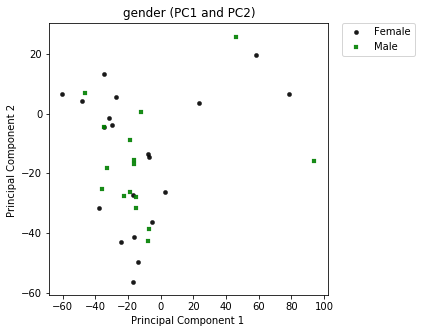

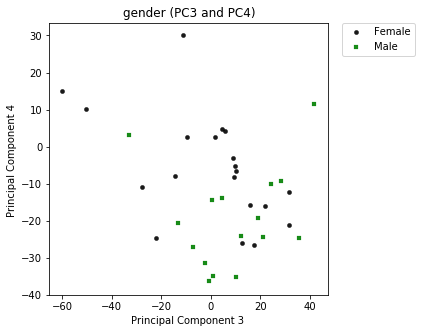

COAD


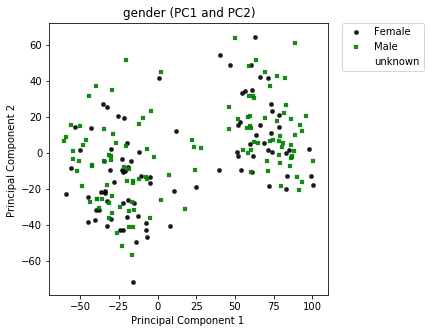

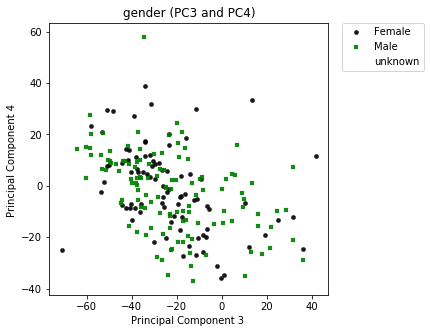

DLBC


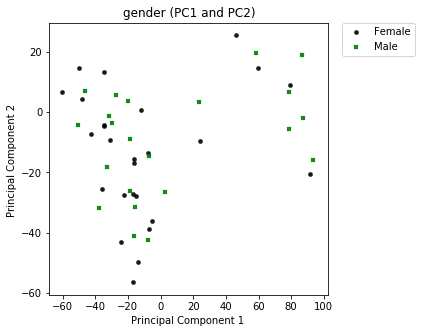

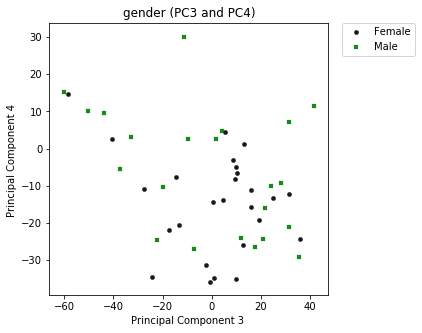

GBM


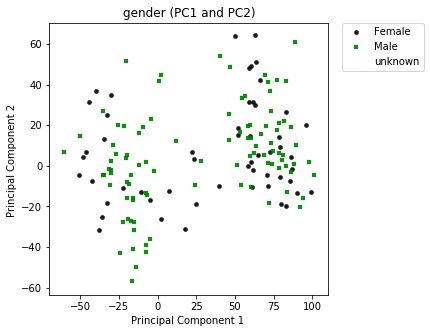

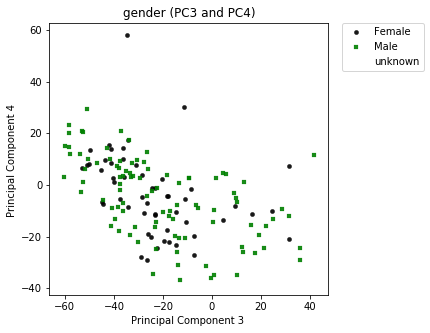

KICH


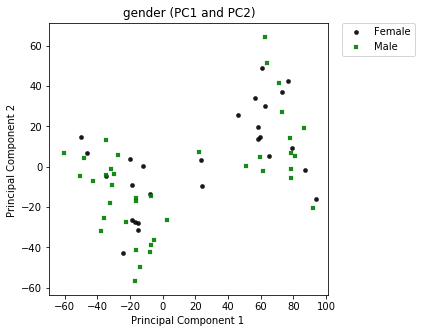

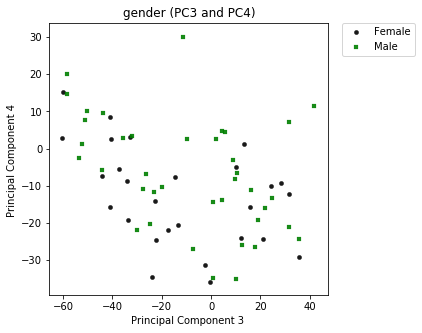

KIRC


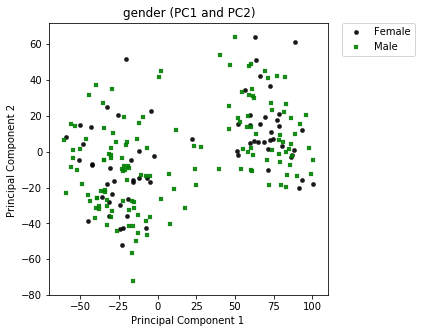

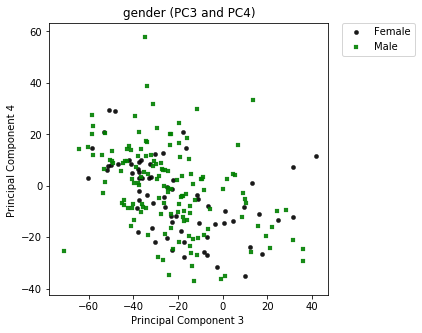

KIRP


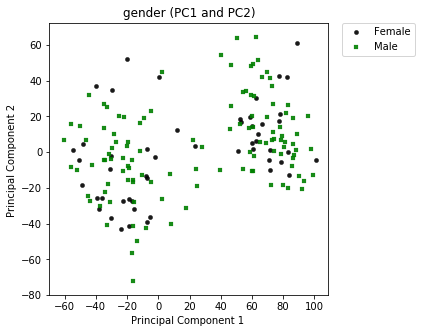

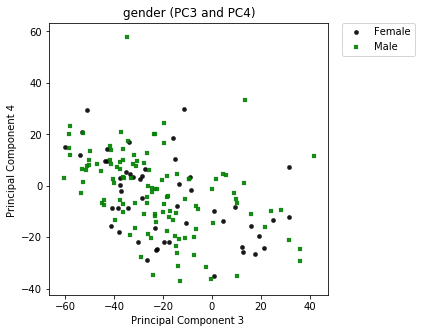

LGG


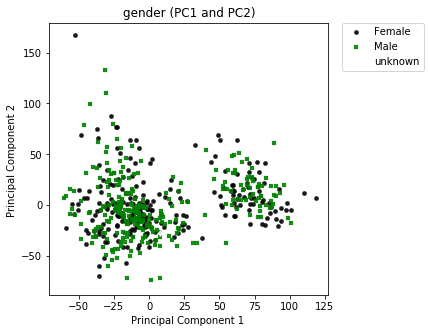

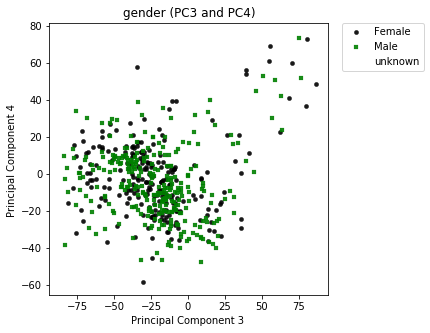

LIHC


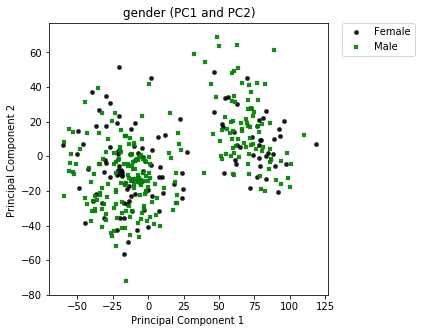

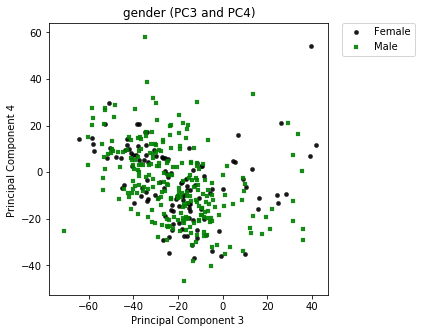

LUAD


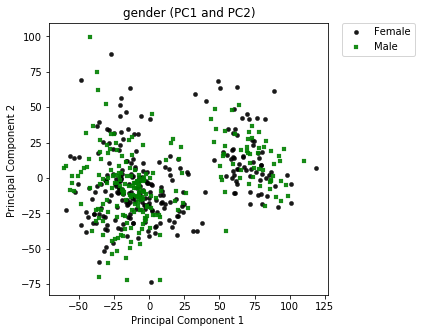

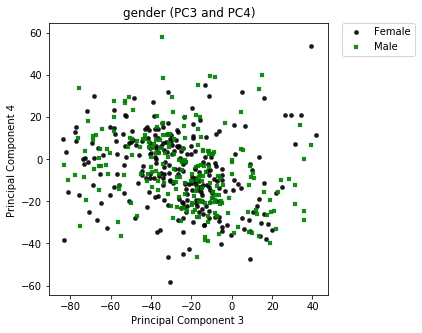

PAAD


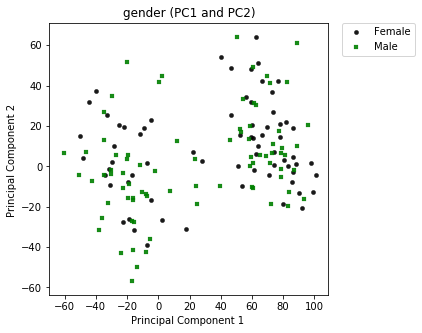

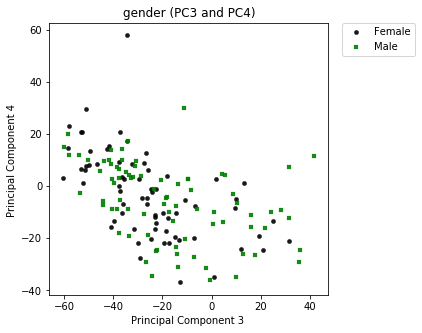

PCPG


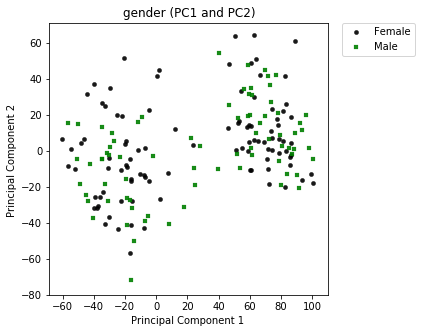

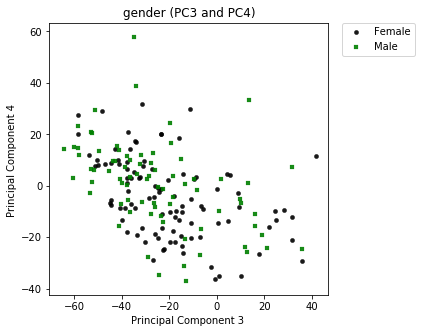

READ


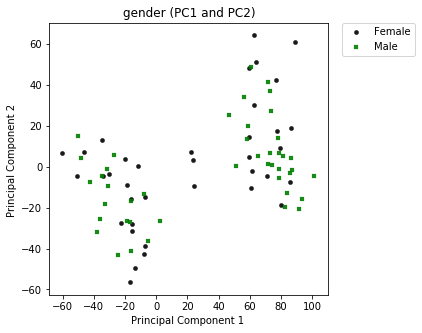

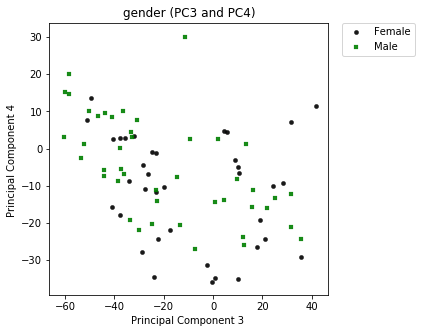

SARC


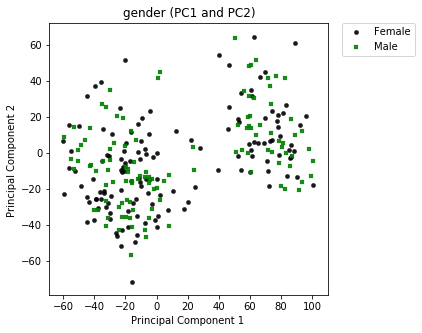

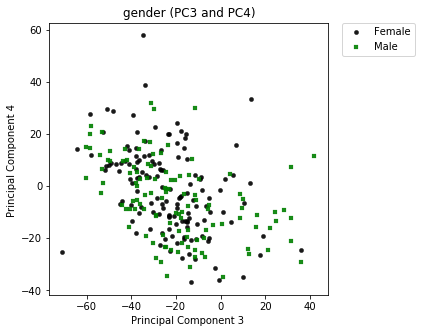

SKCM


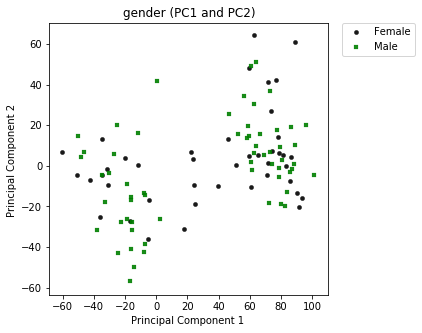

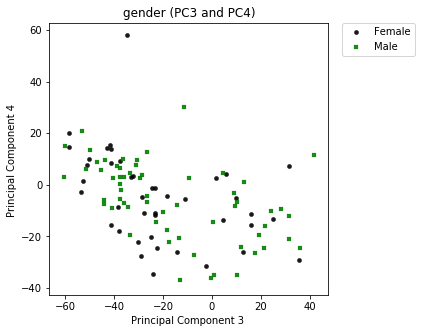

STAD


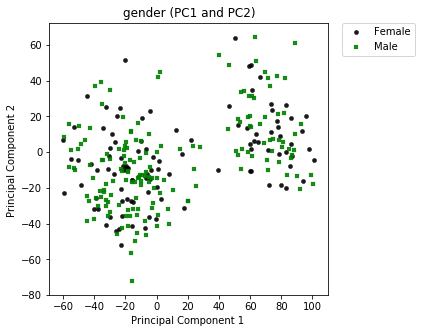

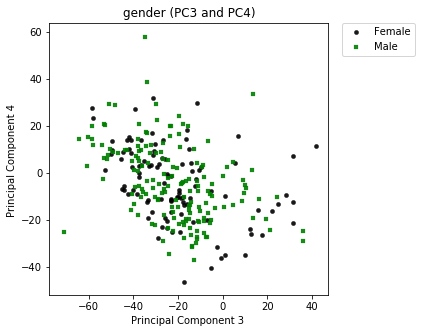

THYM


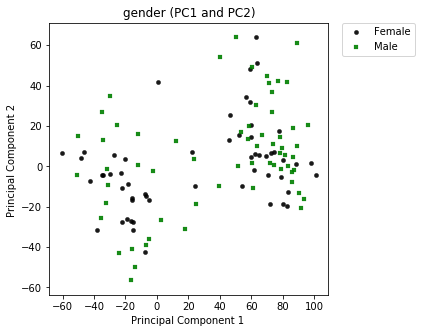

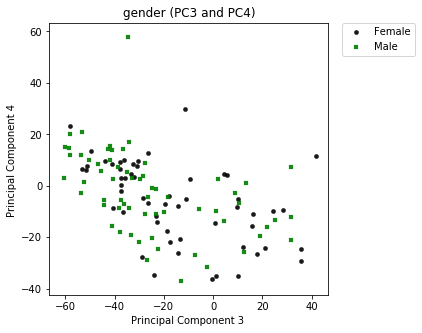

UVM


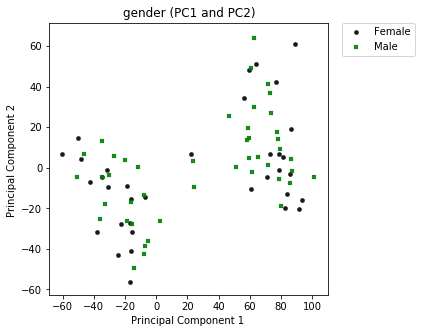

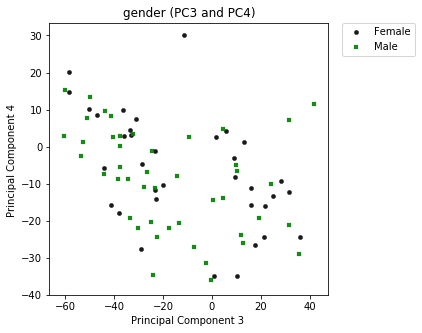

BRCA


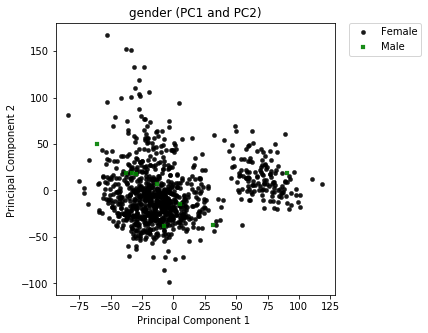

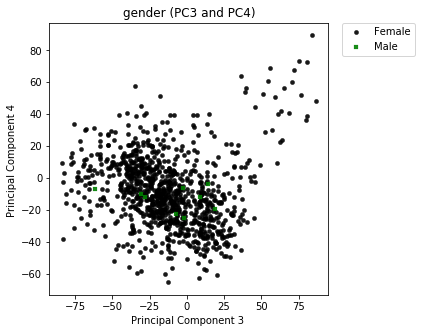

In [17]:
expressionDiseaseAndGender =pd.concat([X, samples['acronym'],samples['gender']], axis=1)
for disease in neutralDiseaseList:
    # Create dataframe
    tempDF = expressionDiseaseAndGender.loc[expressionDiseaseAndGender['acronym'] == disease].copy()
    X_temp = tempDF.drop(['acronym','gender'], 1)
    # Run PCA
    X_temp_scaled = StandardScaler().fit_transform(X_temp)
    temp_pca = PCA(n_components = 10, random_state = RandomSeed)
    temp_pca.fit(X_temp_scaled)
    X_temp_pca = temp_pca.transform(X_temp_scaled)
    
    # Plot PCs and Gender
    print(disease)
    PlotAttributesMultiPlots(4,attribute='gender', X=X_temp_pca, samples=tempDF, colors=['k','g','w'])